In [1]:
import yfinance as yf
import datetime
from datetime import timedelta
from os.path import exists
import pandas as pd

class YahooData:
    def __init__(self, startDate, endDate):
        self.startDate = startDate
        self.endDate = endDate

    def getYahooData(self, keyword):
        historical_data = yf.download(keyword, start=self.startDate, end=self.endDate, progress=False)
        #historical_data = yahoo.get_historical(self.startDate, self.endDate)
        return historical_data
    
file_exists = exists('../Data/yahoo_data.dat')

if file_exists is False:
    historical_data = YahooData('1999-01-04','2011-04-29').getYahooData('EURUSD=X')
    historical_data.to_pickle('../Data/yahoo_data.dat')
else:
    print('Reading existing file...')
    historical_data = pd.read_pickle('../Data/yahoo_data.dat')

Reading existing file...


In [2]:
historical_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-10-09,1734.030029,1742.699951,1727.739990,1738.119995,1738.119995,206822800
2003-10-10,1747.520020,1760.770020,1744.839966,1746.040039,1746.040039,192486400
2003-10-13,1746.319946,1751.729980,1732.349976,1750.780029,1750.780029,186929000
2003-10-14,1757.709961,1764.130005,1728.060059,1730.729980,1730.729980,251716600
2003-10-15,1736.030029,1751.459961,1729.979980,1748.959961,1748.959961,156127200
...,...,...,...,...,...,...
2006-10-03,2593.590088,2598.989990,2579.199951,2593.270020,2593.270020,220924900
2006-10-04,2596.879883,2603.639893,2589.739990,2602.919922,2602.919922,145374200
2006-10-05,2613.330078,2641.479980,2612.320068,2641.479980,2641.479980,208230900


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

yahoo_variables = historical_data.to_numpy()[:,[0,1,2]]
yahoo_close_price = historical_data.to_numpy()[:,3]

x_train, x_test, y_train, y_test = train_test_split(yahoo_variables, yahoo_close_price, train_size=0.80, shuffle=False)

sc_x = MinMaxScaler(feature_range=(0,1))
sc_y = MinMaxScaler(feature_range=(0,1))

x_train = sc_x.fit_transform(x_train)
x_test = sc_x.fit_transform(x_test)

y_train = sc_y.fit_transform(y_train.reshape(-1, 1))
y_test = sc_y.fit_transform(y_test.reshape(-1, 1))

## Implementation of RBF


In [4]:
from keras import backend as K
from tensorflow.keras.layers import Layer
from keras.initializers import RandomUniform, Initializer, Constant
import numpy as np
import tensorflow as tf

class InitCentersRandom(Initializer):

    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]
        idx = np.random.randint(self.X.shape[0], size=shape[0])
        # type checking to access elements of data correctly
        if type(self.X) == np.ndarray:
            return self.X[idx, :]
        elif type(self.X) == pd.core.frame.DataFrame:
            return self.X.iloc[idx, :]


class RBFLayer(Layer):

    def __init__(self, output_dim, y, initializer=None, betas=1.0, **kwargs):
        self.y = y
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(value=self.init_betas),
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        value = K.exp(-self.betas * K.sum(H**2, axis=1))
        #print('Value',value)
        #print(type(value))
        return value

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [5]:
from keras.models import Sequential
from keras.layers.core import Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
rbflayer = RBFLayer(10, y_train, initializer=InitCentersRandom(x_train), betas=0.008, input_shape=(3,))
model.add(rbflayer)
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=RMSprop())

model.fit(x_train, y_train,
          batch_size=30,
          epochs=250,
          verbose=0)

y_pred = model.predict(x_test)

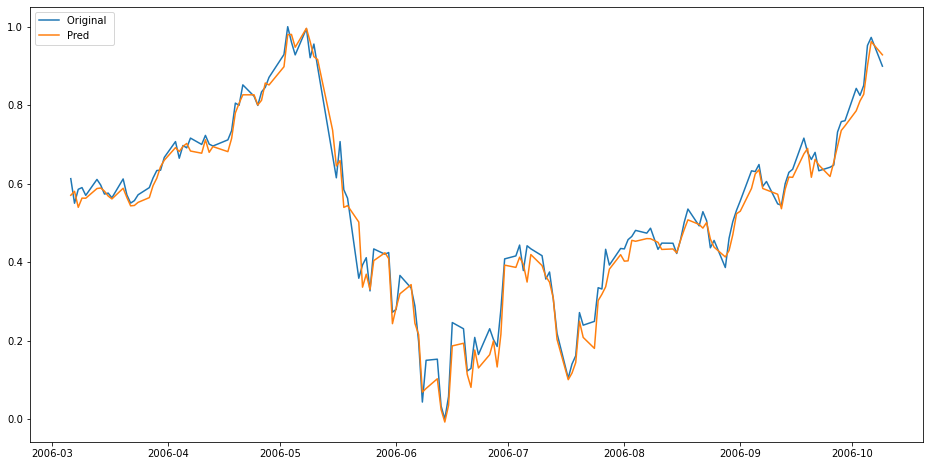

In [6]:
import matplotlib.pyplot as plt

dates = historical_data.index

plt.figure(figsize=(16,8))
#Real values
plt.plot(dates[-y_test.size:], y_test, label='Original ')#sc_y.inverse_transform(y_test)
#Predicted values
plt.plot(dates[-y_test.size:], y_pred, label='Pred ')
#Legend location
plt.legend(loc = 'best')
    
plt.show()